In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

import os
import sys
import numpy as np
from glob import glob
import dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

from tqdm.notebook import trange, tqdm
from rbfNet import *

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm
decompressor = zstd.ZstdDecompressor()
from rbfNet import *
from tqdm.notebook import trange, tqdm

In [5]:
verbose = False
class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, boundaryFeatures, layers = [32,64,64,2], denseLayer = True, activation = 'relu',
                coordinateMapping = 'polar', n = 8, m = 8, windowFn = None, rbf_x = 'linear', rbf_y = 'linear', batchSize = 32, ignoreCenter = False):
        super().__init__()
        self.centerIgnore = ignoreCenter
#         debugPrint(layers)
        
        self.features = copy.copy(layers)
#         debugPrint(fluidFeatures)
#         debugPrint(boundaryFeatures)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
#         debugPrint(fluidFeatures)

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = activation,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.convs.append(RbfConv(
            in_channels = boundaryFeatures, out_channels = self.features[0],
            dim = 2, size = [n,m],
            rbf = [rbf_x, rbf_y],
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = activation,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=False))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)

        self.features[0] = self.features[0]
#         self.fcs.append(nn.Linear(in_features=96,out_features= 2,bias=False))
        
        for i, l in enumerate(layers[1:-1]):
#             debugPrint(layers[i])
#             debugPrint(layers[i+1])
            self.convs.append(RbfConv(
                in_channels = (3 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 2, size = [n,m],
                rbf = [rbf_x, rbf_y],
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
            self.fcs.append(nn.Linear(in_features=3 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=False))
            torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2], out_channels = self.features[-1],
                dim = 2, size = [n,m],
                rbf = [rbf_x, rbf_y],
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False))
        self.fcs.append(nn.Linear(in_features=layers[-2],out_features=self.features[-1],bias=False))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)


    def forward(self, \
                fluidPositions, boundaryPositions, \
                fluidFeatures, boundaryFeatures,\
                attributes, fluidBatches = None, boundaryBatches = None):
        fi, fj = radius(fluidPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = fluidBatches, batch_y = fluidBatches)
        bf, bb = radius(boundaryPositions, fluidPositions, attributes['support'], max_num_neighbors = 256, batch_x = boundaryBatches, batch_y = fluidBatches)
        if self.centerIgnore:
            nequals = fi != fj

        i, ni = torch.unique(fi, return_counts = True)
        b, nb = torch.unique(bf, return_counts = True)
        ni[i[b]] += nb
        self.li = torch.exp(-1 / np.float32(attributes['targetNeighbors']) * ni)
        
        boundaryEdgeIndex = torch.stack([bf, bb], dim = 0)
        boundaryEdgeLengths = (boundaryPositions[boundaryEdgeIndex[1]] - fluidPositions[boundaryEdgeIndex[0]])/attributes['support']
        boundaryEdgeLengths = boundaryEdgeLengths.clamp(-1,1)
        if self.centerIgnore:
            fluidEdgeIndex = torch.stack([fi[nequals], fj[nequals]], dim = 0)
        else:
            fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
        fluidEdgeLengths = -(fluidPositions[fluidEdgeIndex[1]] - fluidPositions[fluidEdgeIndex[0]])/attributes['support']
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
#         if verbose:
#             print('prepared network with inputs:')
#             print('fluidPositions', fluidPositions[:4])
#             print('fluidFeatures', fluidFeatures[:4])
#             print('boundaryPositions', boundaryPositions[:4])
#             print('boundaryFeatures', boundaryFeatures[:4])
#             print('fluid neighbors:', fluidEdgeIndex.shape)
#             print('fluid neighbor distances', fluidEdgeLengths[:4])
#             print('boundary neighbors:', boundaryEdgeIndex.shape)
#             print('boundary neighbor distances', boundaryEdgeLengths[:4])
#             print('num neighbors', ni[:4])
#             print('li', self.li[:4])
            
            
        linearOutput = self.relu(self.fcs[0](fluidFeatures))
        boundaryConvolution = self.convs[1]((fluidFeatures, boundaryFeatures), boundaryEdgeIndex, boundaryEdgeLengths)
        fluidConvolution = self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths)
        ans = torch.hstack((linearOutput, fluidConvolution, boundaryConvolution))
        if verbose:
#             print('linear output', linearOutput[:4])
#             print('boundary convolution output', boundaryConvolution[:4])
#             print('fluid convolution output', fluidConvolution[:4])
            print('first layer output', ans[:4])
        
        layers = len(self.convs)
        for i in range(2,layers):
            ansConv = self.convs[i]((ans, ans), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.fcs[i - 1](ans)
            
            
            if self.features[i-2] == self.features[i-1] and ans.shape == ansConv.shape:
                ans = ansConv #+ ansDense + ans
            else:
                ans = ansConv #+ ansDense
#             if verbose:
#                 print('\tlayer', i)
#                 print('\tlinear output', ansDense[:4])
#                 print('\tfluid convolution output', ansConv[:4])
#                 print('\tlayer output', ans[:4])
                
            if i != layers - 1:
                ans = self.relu(ans)
            if verbose:
                print('\tlayer output after activation', ans[:4])
        return ans

def loadRbfModel(file, frame, networkPath, epoch):
    with open(os.path.expanduser("%s/results.json" % networkPath), "r") as read_file:
        decodedArray = json.load(read_file)
        dataDict = decodedArray
    
    n = dataDict['hyperParameters']['n']
    m = dataDict['hyperParameters']['m']
    coordinateMapping = dataDict['hyperParameters']['coordinateMapping']
    windowFn = getWindowFunction(dataDict['hyperParameters']['windowFunction'])
    rbf_x = dataDict['hyperParameters']['rbf_x']
    rbf_y = dataDict['hyperParameters']['rbf_y']
    dist = dataDict['hyperParameters']['frameDistance']
    unroll = dataDict['hyperParameters']['maxRollOut']
    arch = [32, 64, 64, 2]
    arch = [16, 32, 32, 2]
    arch = dataDict['hyperParameters']['arch']
    print(arch)

    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(unroll), dist)
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
    
    model = RbfNet(fluidFeatures.shape[1], boundaryFeatures.shape[1], coordinateMapping = coordinateMapping, n = n, m = m, windowFn = windowFn, rbf_x = rbf_x, rbf_y = rbf_y, batchSize = 32)
    model.load_state_dict(torch.load(os.path.expanduser('%s/model_%03d.torch' % (networkPath, epoch))))
    model = model.to(device)
    model.train(False)
    return model
def getRbfNetworkParams(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
    fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)    
    return inputData['fluidGravity'].to(device), fluidFeatures.to(device), boundaryPositions.to(device), boundaryFeatures.to(device)
def computeRbfNetworkLoss(predictedPosition, predictedVelocity, groundTruth, modelOutput):
    posLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,:2] - predictedPosition, dim = 1))
    return posLoss
    velLoss = torch.sqrt(torch.linalg.norm(groundTruth[:,2:4] - predictedVelocity, dim = 1))
    return posLoss + velLoss    
def runRbfNetwork(initialPosition, initialVelocity, dt, frameDistance, params, gt, computeLoss = False, li = True):
    d = (frameDistance) * ((frameDistance) + 1) / 2
    gravity, fluidFeatures, boundaryPositions, boundaryFeatures = params   
    
    vel2 = initialVelocity + frameDistance * dt * gravity
    pos2 = initialPosition + frameDistance * dt * initialVelocity + d * dt**2 * gravity
    
    fluidFeatures = torch.hstack((fluidFeatures[:,0][:,None], vel2, fluidFeatures[:,3:]))
    predictions = model(pos2, boundaryPositions, fluidFeatures, boundaryFeatures, attributes, None, None)

    predictedVelocity = (pos2 + predictions - initialPosition) / (frameDistance * attributes['dt'])
    predictedPositions = pos2 + predictions[:,:2]
    if computeLoss:        
        if li:
            loss = model.li * computeRbfNetworkLoss(predictedPositions, predictedVelocity, torch.hstack(gt), predictions)
        else:
            loss = computeRbfNetworkLoss(predictedPositions, predictedVelocity, torch.hstack(gt), predictions)

        return predictedPositions, predictedVelocity, loss
    else:
        return predictedPositions, predictedVelocity


In [7]:
def getGroundTruth(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    return inputData['fluidPosition'].to(device), inputData['fluidVelocity'].to(device)

extension = '.hdf5'

basePath = os.path.expanduser('~/dev/datasets/WBCSPH2Dc')
trainFiles = glob(os.path.join(os.path.join(basePath, 'train'), '*' + extension))
validFiles = glob(os.path.join(os.path.join(basePath, 'valid'), '*' + extension))
testFiles = glob(os.path.join(os.path.join(basePath, 'test'), '*' + extension))

# print(trainFiles)
# print(validFiles)
# print(testFiles)

simulationFiles = sorted(trainFiles + validFiles + testFiles)
# simulationFiles = ['/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0043.hdf5']

simFiles = ['/'.join(s.split('/')[-2:]) for s in simulationFiles]
debugPrint(simFiles)

frameCounts = []
fluidCounts = []
boundaryCounts = []

for s in tqdm(simulationFiles): 
    inFile = h5py.File(s)
    length = len(inFile['simulationExport'].keys())
    numFluids = inFile['simulationExport']['00000']['fluidPosition'].shape[0]
    numBoundary = inFile['boundaryInformation']['boundaryPosition'].shape[0]
    inFile.close()
    frameCounts.append(length)
    fluidCounts.append(numFluids)
    boundaryCounts.append(numBoundary)
    print('simulation %s has %4d frames, %5d fluid ptcls, %5d bdy ptcls'% ('/'.join(s.split('/')[-2:]).split('.')[0], length, numFluids, numBoundary))

simFiles [list] = ['train/sim_0000.hdf5', 'train/sim_0002.hdf5', 'train/sim_0003.hdf5', 'train/sim_0004.hdf5', 'train/sim_0005.hdf5', 'train/sim_0006.hdf5', 'train/sim_0007.hdf5', 'train/sim_0010.hdf5', 'train/sim_0012.hdf5', 'train/sim_0013.hdf5', 'train/sim_0014.hdf5', 'train/sim_0016.hdf5', 'train/sim_0018.hdf5', 'train/sim_0019.hdf5', 'train/sim_0020.hdf5', 'train/sim_0021.hdf5', 'train/sim_0022.hdf5', 'train/sim_0023.hdf5', 'train/sim_0024.hdf5', 'train/sim_0026.hdf5', 'train/sim_0028.hdf5', 'train/sim_0029.hdf5', 'train/sim_0030.hdf5', 'train/sim_0031.hdf5', 'train/sim_0032.hdf5', 'train/sim_0033.hdf5', 'train/sim_0034.hdf5', 'train/sim_0036.hdf5', 'train/sim_0039.hdf5', 'train/sim_0040.hdf5', 'train/sim_0043.hdf5', 'train/sim_0045.hdf5', 'train/sim_0046.hdf5', 'train/sim_0047.hdf5', 'train/sim_0048.hdf5']


  0%|          | 0/35 [00:00<?, ?it/s]

simulation train/sim_0000 has 3200 frames,  7062 fluid ptcls, 16057 bdy ptcls
simulation train/sim_0002 has 3200 frames, 10494 fluid ptcls, 14447 bdy ptcls
simulation train/sim_0003 has 3200 frames,  8510 fluid ptcls,  8758 bdy ptcls
simulation train/sim_0004 has 3200 frames,  3286 fluid ptcls, 13509 bdy ptcls
simulation train/sim_0005 has 3200 frames, 10030 fluid ptcls, 13467 bdy ptcls
simulation train/sim_0006 has 2000 frames, 11166 fluid ptcls, 15099 bdy ptcls
simulation train/sim_0007 has 3200 frames,  6081 fluid ptcls, 10154 bdy ptcls
simulation train/sim_0010 has 3200 frames,  8250 fluid ptcls, 18085 bdy ptcls
simulation train/sim_0012 has 3200 frames,  5190 fluid ptcls, 16535 bdy ptcls
simulation train/sim_0013 has 3200 frames,  9445 fluid ptcls,  9094 bdy ptcls
simulation train/sim_0014 has 1200 frames,  2618 fluid ptcls, 18328 bdy ptcls
simulation train/sim_0016 has 3200 frames,  2149 fluid ptcls, 12676 bdy ptcls
simulation train/sim_0018 has 3200 frames,  5997 fluid ptcls, 15

In [8]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    GTsc.set_offsets(positions)
    GTsc.set_array(data)
    GTcbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def getFrameCount(file):
    if 'zst' in file:
        with open(os.path.expanduser(file), 'rb') as f:
            data = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)
            
#             print(data[0]['grav'])
            return len(data)
    if 'hdf5' in file:        
        inFile = h5py.File(file)
        length = len(inFile['simulationExport'].keys())
#         print(inFile.attrs['fluidGravity'])
        inFile.close()
        return length

In [9]:
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>


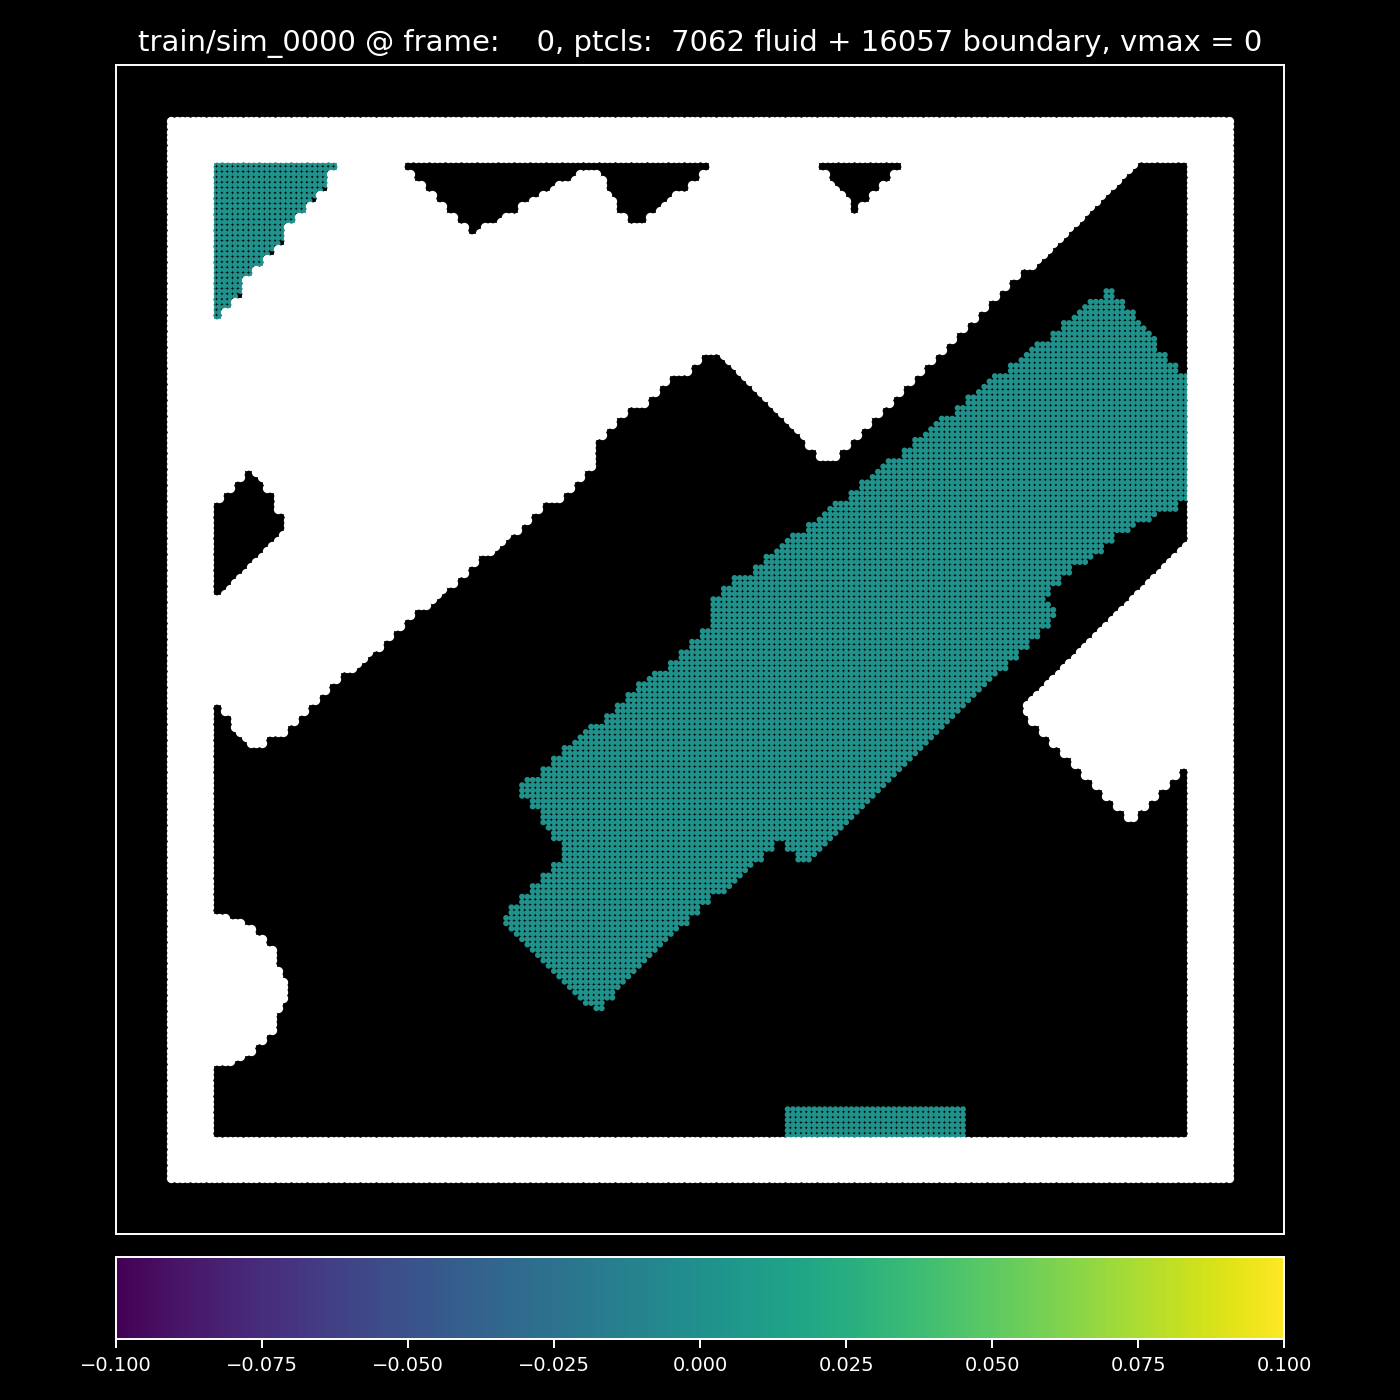

/home/winchenbach/anaconda3/envs/torch/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='fileName', options=('train/sim_0000.hdf5', 'train/sim_0002.hdf5', …

<function __main__.plotNetwork(fileName, frame)>

In [10]:
fig, axis = plt.subplots(1, 1, figsize=(8,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)
GTsc = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
bdyScatter = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )


ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
GTcbar = fig.colorbar(GTsc, cax=cax1,orientation='horizontal')
GTcbar.ax.tick_params(labelsize=8) 
axis[0,0].set_title('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)




In [11]:
import subprocess
import shlex

def createOutputs(simulationFile):
    file = basePath + '/' + simulationFile
    
    inFile = h5py.File(file, 'r')
    frameCount = int(len(inFile['simulationExport'].keys()) -1) # adjust for bptcls
    inFile.close()

    
    imageFolder = '../images/%s/' % simulationFile.split('.')[0].replace('/','_')
#     print(imageFolder)
#     break
    
    if not os.path.exists(imageFolder):
        os.makedirs(imageFolder)
        for i in tqdm(range(0, frameCount, 8), leave = False):
            plotNetwork(simulationFile, i)
            imagePath = '../images/%s/%04d.png' % (simulationFile.split('.')[0].replace('/','_'), i)
            plt.savefig(imagePath, dpi = 200)
#         print('converting to video')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -framerate 50 -f image2 -pattern_type glob -i '*.png' -c:v libx264 -b:v 20M -r 50 out.mp4"), cwd='../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
#         print('Creating video gif')
        p = subprocess.Popen(shlex.split("/usr/bin/ffmpeg -y -hide_banner -loglevel error -i out.mp4 -filter_complex 'fps=50,scale=720:-1:flags=lanczos,split[s0][s1];[s0]palettegen=max_colors=32[p];[s1][p]paletteuse=dither=bayer' output.gif"), cwd='../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
#         print('Copying output')
        p = subprocess.Popen(shlex.split('cp output.gif ../%s.gif' % (simulationFile.split('.')[0].replace('/','_')).replace(' ','_')), cwd = '../images/%s/' % simulationFile.split('.')[0].replace('/','_'))
        p.wait()
    else:
        print('nothing to do for %s' % simulationFile)
    return
    

In [12]:
# for s in tqdm(simFiles):
#     createOutputs(s)

In [13]:
networkPath = './trainingData/cconvlike - n=[ 4, 4] rbf=[linear,linear] map = preserving window = Spiky d =  1 e = 25 distance =  1 - 2023-03-01_15-20-30'
model = loadRbfModel(simulationFiles[0],0, networkPath, 1)

fileName = simulationFiles[0]
frameIndex = 100
    
params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, frameIndex + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']

predictedPositions, predictedVelocities = runRbfNetwork(predictedPositions, predictedVelocities, attributes['dt'], 1, params, gt, False)

[32, 64, 64, 2]


<IPython.core.display.Javascript object>


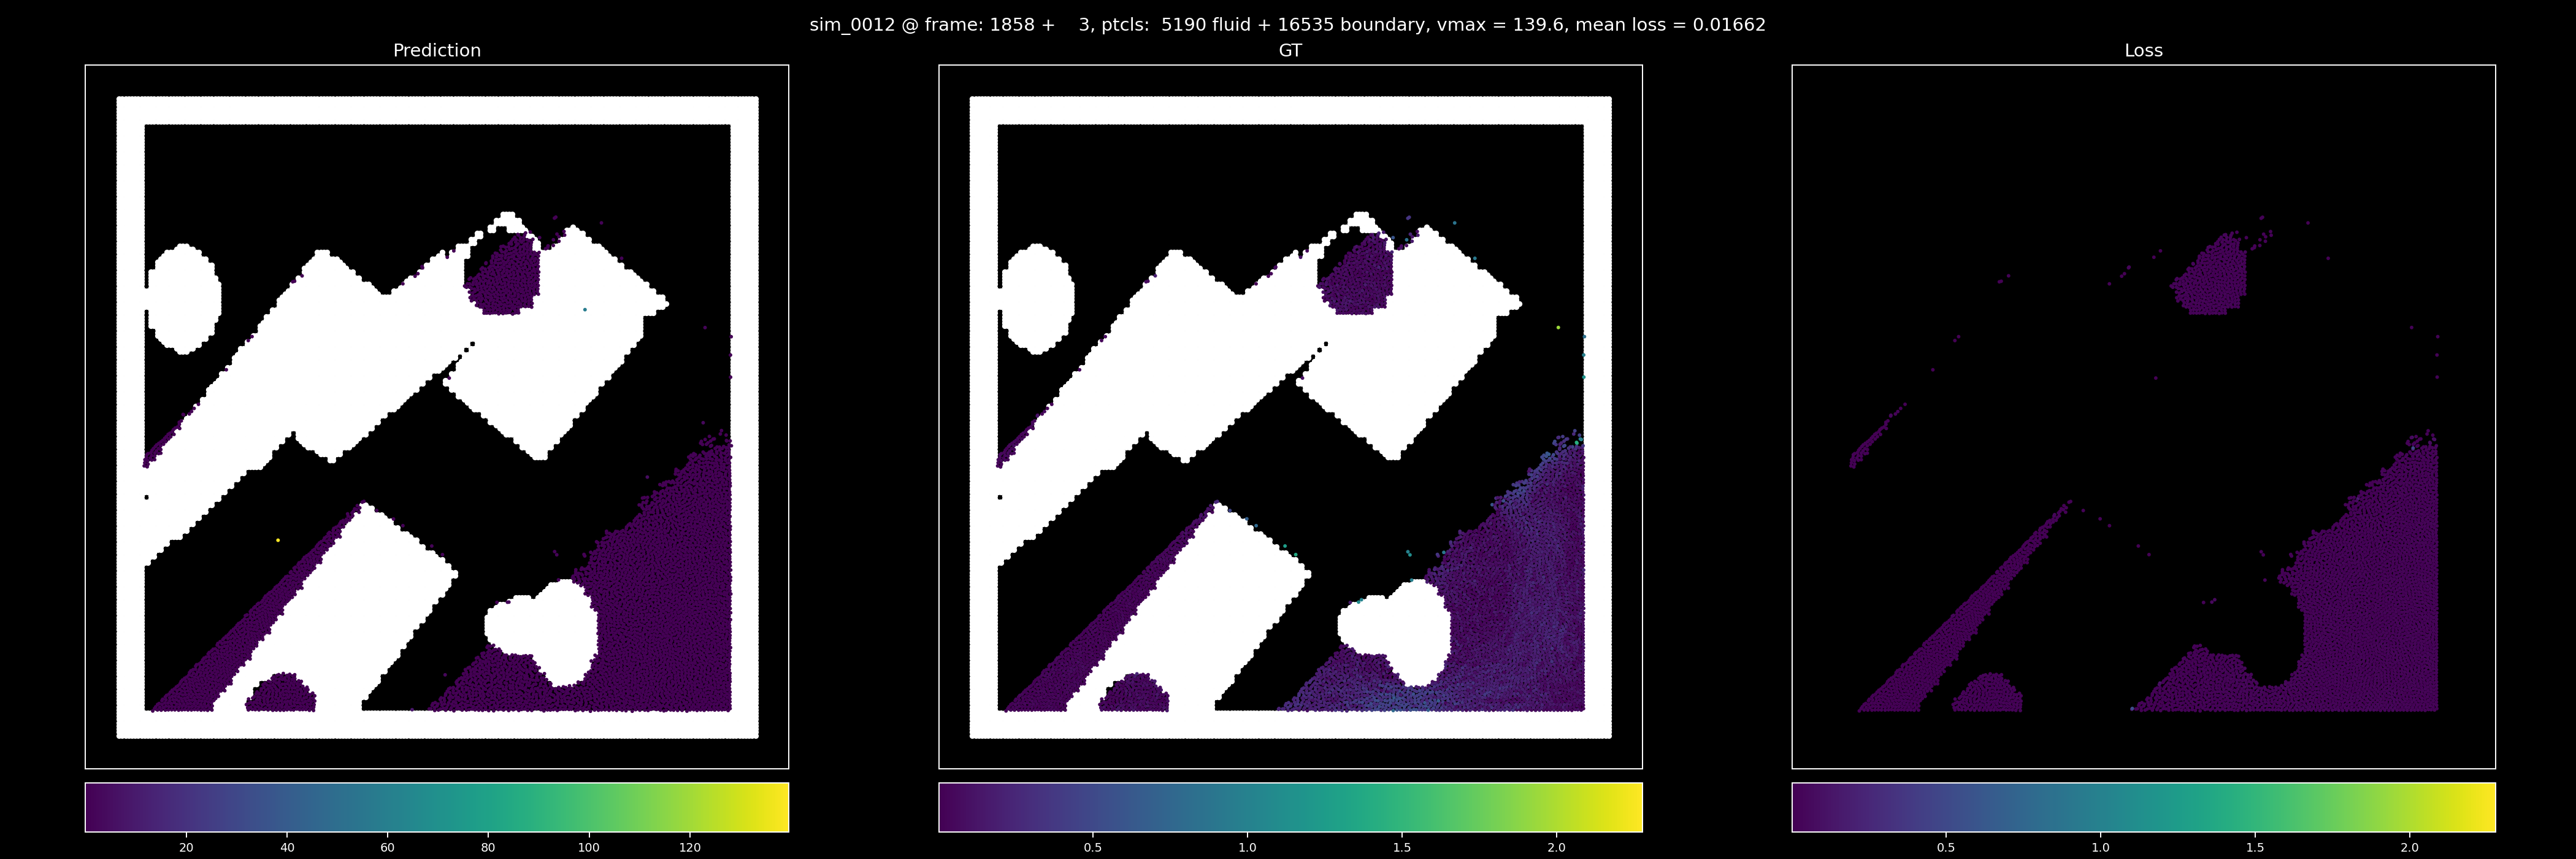

interactive(children=(Dropdown(description='fileName', options=('train/sim_0000.hdf5', 'train/sim_0002.hdf5', …

<function __main__.plotNetwork(fileName, frame)>

In [14]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter0.set_offsets(inputData['boundaryPosition'][:,:2])
        bdyScatter1.set_offsets(inputData['boundaryPosition'][:,:2])
#         bdyScatter2.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    sc0.set_offsets(positions)
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    sc1.set_offsets(positions)
    sc1.set_array(data)
    cbar1.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    sc2.set_offsets(positions)
    sc2.set_array(data)
    cbar2.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    
#     axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.suptitle('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
   

fig, axis = plt.subplots(1, 3, figsize=(24,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-0.05,1.05)
axis[0,1].set_ylim(-0.05,1.05)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-0.05,1.05)
axis[0,2].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

bdyScatter0 = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
bdyScatter1 = axis[0,1].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
# bdyScatter2 = axis[0,2].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )

sc0 = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar0 = fig.colorbar(sc0, cax=cax1,orientation='horizontal')
cbar0.ax.tick_params(labelsize=8) 

sc1 = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar1 = fig.colorbar(sc1, cax=cax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=8) 

sc2 = axis[0,2].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar2 = fig.colorbar(sc2, cax=cax1,orientation='horizontal')
cbar2.ax.tick_params(labelsize=8) 

fig.suptitle('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
axis[0,0].set_title('Prediction')
axis[0,1].set_title('GT')
axis[0,2].set_title('Loss')
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
axis[0,1].set_xticks([], [])
axis[0,1].set_yticks([], [])
axis[0,2].set_xticks([], [])
axis[0,2].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)

In [21]:
print(prevFile)
print(prevFrame)
fileName = prevFile
frameIndex = prevFrame
    
params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 0 + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']


for i in range(1, 4):
    gt = getGroundTruth(fileName, prevFrame + i)
    predictedPositions, predictedVelocities, loss = runRbfNetwork(predictedPositions, predictedVelocities, attributes['dt'], 1, params, gt, True)
    
    data = np.linalg.norm(predictedVelocities.detach().cpu().numpy(),axis=1)    
    sc0.set_offsets(predictedPositions.detach().cpu().numpy())
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    
    gtdata = np.linalg.norm(gt[1].detach().cpu().numpy(), axis = 1)
    sc1.set_offsets(gt[0].detach().cpu().numpy())
    sc1.set_array(gtdata)
    sc2.set_offsets(gt[0].detach().cpu().numpy())
    sc2.set_array(loss.detach().cpu().numpy())
    
    fig.suptitle('%s @ frame: %4d + %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g, mean loss = %.4g' % (prevFile.split('/')[-1].split('.')[0], prevFrame, i, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data), np.mean(loss.detach().cpu().numpy())))
    fig.canvas.draw()
    fig.canvas.flush_events()
    


/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0012.hdf5
1858


In [52]:
inFile.close()

In [1]:
from DMCF.o3d.utils import convert_device_name, Config
import tensorflow as tf
from DMCF.datasets import DatasetGroup
import DMCF.pipelines
import DMCF.models

import multiprocessing

multiprocessing.set_start_method('spawn', True)

import random
import numpy as np


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-03-01 21:58:43.956268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-01 21:58:43.980518: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-01 21:58:43.981072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import argparse
import copy
import os
import sys
import os.path as osp
from pathlib import Path
import yaml
import time
import pprint
import importlib

def parse_args():
    parser = argparse.ArgumentParser(description='Train a network')
    parser.add_argument('-c', '--cfg_file', help='path to the config file')
    parser.add_argument('-m', '--model', help='network model')
    parser.add_argument('-p',
                        '--pipeline',
                        help='pipeline',
                        default='DefaultGenerator')
    parser.add_argument('-d', '--dataset', help='dataset')
    parser.add_argument('--cfg_model', help='path to the model\'s config file')
    parser.add_argument('--cfg_pipeline',
                        help='path to the pipeline\'s config file')
    parser.add_argument('--cfg_dataset',
                        help='path to the dataset\'s config file')
    parser.add_argument('--dataset_path', help='path to the dataset')
    parser.add_argument('--ckpt_path', help='path to the checkpoint')
    parser.add_argument('--device',
                        help='device to run the pipeline',
                        default='gpu')
    parser.add_argument('--split', help='train or test', default='train')
    parser.add_argument('--regen',
                        help='Regenerates data, overwrites cache',
                        default=False,
                        action='store_true')
    parser.add_argument(
        '--restart',
        help='Restart training, resume if false (overwrites checkpoints!)',
        default=False,
        action='store_true')
    parser.add_argument('--main_log_dir',
                        help='the dir to save logs and models')
    parser.add_argument('--output_dir', help='the dir to save outputs')

#     args, unknown = parser.parse_known_args("--cfg_file DMCF/configs/WBC-SPH.yml --dataset_path ../../datasets/WBCSPH2D --split train --ckpt_path DMCF/checkpoints/WBC-SPH/ckpt".split())
    args, unknown = parser.parse_known_args("--cfg_file DMCF/configs/other/cconv.yml --dataset_path ../../datasets/WBCSPH2Dc --split train --ckpt_path DMCF/logs/CConv_ComplexData_2d/checkpoint/ckpt-51".split())

    parser_extra = argparse.ArgumentParser(description='Extra arguments')
    for arg in unknown:
        if arg.startswith(("-", "--")):
            parser_extra.add_argument(arg)
    args_extra = parser_extra.parse_args(unknown)

    print("regular arguments")
    print(yaml.dump(vars(args)))

    print("extra arguments")
    print(yaml.dump(vars(args_extra)))

    return args, vars(args_extra)

In [3]:
args, extra_dict = parse_args()

regular arguments
cfg_dataset: null
cfg_file: DMCF/configs/other/cconv.yml
cfg_model: null
cfg_pipeline: null
ckpt_path: DMCF/logs/CConv_ComplexData_2d/checkpoint/ckpt-51
dataset: null
dataset_path: ../../datasets/WBCSPH2Dc
device: gpu
main_log_dir: null
model: null
output_dir: null
pipeline: DefaultGenerator
regen: false
restart: false
split: train

extra arguments
{}



In [4]:


# cfg = Config.load_from_file('./DMCF/configs/WBC-SPH.yml')
cfg = Config.load_from_file('./DMCF/configs/other/cconv.yml')

Pipeline = getattr(DMCF.pipelines, cfg.pipeline.name)
Model = getattr(DMCF.models, cfg.model.name)

cfg_dict_dataset, cfg_dict_pipeline, cfg_dict_model = \
                Config.merge_cfg_file(cfg, args, extra_dict)

dataset = DatasetGroup(**cfg_dict_dataset,
                       split=args.split,
                       regen=args.regen)
model = Model(**cfg_dict_model)
pipeline = Pipeline(model,
                    dataset,
                    **cfg_dict_pipeline,
                    restart=args.restart)

['../../datasets/WBCSPH2Dc/train/sim_0000.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0002.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0003.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0004.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0005.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0006.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0007.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0010.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0012.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0013.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0014.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0016.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0018.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0019.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0020.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0021.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0022.msgpack.zst', '../../datasets/WBCSPH2Dc/train/sim_0023.msgpack.zst', '../../da

2023-03-01 21:58:44.024200: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 21:58:44.026594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-01 21:58:44.027042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-01 21:58:44.027479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built witho

In [5]:

model = Model(**cfg_dict_model)
# model.init()
# model.load_weights('./DMCF/checkpoints/WBC-SPH/', by_name=True)


In [6]:

cmd_line = ' '.join(sys.argv[:])
    
pipeline.cfg_tb = {
    'cmd_line': cmd_line,
    'dataset': pprint.pformat(cfg_dict_dataset, indent=2),
    'model': pprint.pformat(cfg_dict_model, indent=2),
    'pipeline': pprint.pformat(cfg_dict_pipeline, indent=2)
}

In [7]:
# pipeline.load_ckpt(model.cfg.ckpt_path)

In [8]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 0
Trainable params: 0
Non-trainable params: 0


In [9]:
pipeline.run_train()

INFO - 2023-03-01 21:58:45,402 - simulator - Logging in file : ./logs/CConv_ComplexData_2d/log_train_2023-03-01_21:58:45.txt
INFO - 2023-03-01 21:58:45,410 - base_pipeline - Restored from DMCF/logs/CConv_ComplexData_2d/checkpoint/ckpt-51
INFO - 2023-03-01 21:58:45,411 - simulator - Writing summary in ./train_log/00015_CConv_ComplexData_2d.
INFO - 2023-03-01 21:58:45,412 - simulator - Started training
INFO - 2023-03-01 21:58:45,413 - simulator - === EPOCH 0/50 ===
training:   0%|                                                                                | 0/1000 [00:00<?, ?it/s]

adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output
adding bias to output


2023-03-01 21:58:55.700624: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
INFO - 2023-03-01 21:58:55,887 - base_pipeline - ###################################
INFO - 2023-03-01 21:58:55,888 - base_pipeline - Parameter count 'CConv':
INFO - 2023-03-01 21:58:55,888 - base_pipeline -  Total params: 183,718
INFO - 2023-03-01 21:58:55,889 - base_pipeline -  Trainable params: 183,718
INFO - 2023-03-01 21:58:55,889 - base_pipeline -  Non-trainable params: 0
INFO - 2023-03-01 21:58:55,890 - base_pipeline - -----------------------------------
training:   0%|                                                                                | 0/1000 [00:10<?, ?it/s]


In [107]:
pipeline.model

In [15]:
pipeline.model.convs[0].use_bias

True

In [108]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(pipeline.model.trainable_weights)
non_trainable_count = count_params(pipeline.model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 183,718
Trainable params: 183,718
Non-trainable params: 0


In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import time
import torch
from torch_geometric.loader import DataLoader
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
# from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
%matplotlib notebook
import copy

import time
import torch
from torch_geometric.loader import DataLoader
from tqdm.notebook import trange, tqdm
import argparse
import yaml
from torch_geometric.nn import radius
from torch.optim import Adam
import torch.autograd.profiler as profiler
from torch.profiler import profile, record_function, ProfilerActivity

from rbfConv import RbfConv
from dataset import compressedFluidDataset, prepareData

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))


import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

seed = 0


import random 
import numpy as np
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('running on: ', device)
torch.set_num_threads(1)

from joblib import Parallel, delayed

from cutlass import *
from rbfConv import *
from tqdm.notebook import tqdm

from datautils import *
# from sphUtils import *
from lossFunctions import *

import os
import sys
import numpy as np
from glob import glob
import dataflow
import numpy as np
import zstandard as zstd
import msgpack
import msgpack_numpy
msgpack_numpy.patch()

from tqdm.notebook import trange, tqdm
from rbfNet import *

from plotting import *
plt.style.use('dark_background')
# plt.style.use('default')
from tqdm.notebook import trange, tqdm
decompressor = zstd.ZstdDecompressor()
from rbfNet import *
from tqdm.notebook import trange, tqdm

/home/winchenbach/anaconda3/envs/torch/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/home/winchenbach/anaconda3/envs/torch/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


In [2]:
def getGroundTruth(fileName, frameIndex):
    attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 1 + np.arange(1))
    return inputData['fluidPosition'].to(device), inputData['fluidVelocity'].to(device)
def getFrameCount(file):
    if 'zst' in file:
        with open(os.path.expanduser(file), 'rb') as f:
            data = msgpack.unpackb(decompressor.decompress(f.read()), raw=False)
            
#             print(data[0]['grav'])
            return len(data)
    if 'hdf5' in file:        
        inFile = h5py.File(file)
        length = len(inFile['simulationExport'].keys())
#         print(inFile.attrs['fluidGravity'])
        inFile.close()
        return length

extension = '.hdf5'

basePath = os.path.expanduser('~/dev/datasets/WBCSPH2Dc')
trainFiles = glob(os.path.join(os.path.join(basePath, 'train'), '*' + extension))
validFiles = glob(os.path.join(os.path.join(basePath, 'valid'), '*' + extension))
testFiles = glob(os.path.join(os.path.join(basePath, 'test'), '*' + extension))

# print(trainFiles)
# print(validFiles)
# print(testFiles)

simulationFiles = sorted(trainFiles + validFiles + testFiles)
# simulationFiles = ['/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0043.hdf5']

simFiles = ['/'.join(s.split('/')[-2:]) for s in simulationFiles]
debugPrint(simFiles)

frameCounts = []
fluidCounts = []
boundaryCounts = []

for s in tqdm(simulationFiles): 
    inFile = h5py.File(s)
    length = len(inFile['simulationExport'].keys())
    numFluids = inFile['simulationExport']['00000']['fluidPosition'].shape[0]
    numBoundary = inFile['boundaryInformation']['boundaryPosition'].shape[0]
    inFile.close()
    frameCounts.append(length)
    fluidCounts.append(numFluids)
    boundaryCounts.append(numBoundary)
    print('simulation %s has %4d frames, %5d fluid ptcls, %5d bdy ptcls'% ('/'.join(s.split('/')[-2:]).split('.')[0], length, numFluids, numBoundary))

simFiles [list] = ['train/sim_0000.hdf5', 'train/sim_0002.hdf5', 'train/sim_0003.hdf5', 'train/sim_0004.hdf5', 'train/sim_0005.hdf5', 'train/sim_0006.hdf5', 'train/sim_0007.hdf5', 'train/sim_0010.hdf5', 'train/sim_0012.hdf5', 'train/sim_0013.hdf5', 'train/sim_0014.hdf5', 'train/sim_0016.hdf5', 'train/sim_0018.hdf5', 'train/sim_0019.hdf5', 'train/sim_0020.hdf5', 'train/sim_0021.hdf5', 'train/sim_0022.hdf5', 'train/sim_0023.hdf5', 'train/sim_0024.hdf5', 'train/sim_0026.hdf5', 'train/sim_0028.hdf5', 'train/sim_0029.hdf5', 'train/sim_0030.hdf5', 'train/sim_0031.hdf5', 'train/sim_0032.hdf5', 'train/sim_0033.hdf5', 'train/sim_0034.hdf5', 'train/sim_0036.hdf5', 'train/sim_0039.hdf5', 'train/sim_0040.hdf5', 'train/sim_0043.hdf5', 'train/sim_0045.hdf5', 'train/sim_0046.hdf5', 'train/sim_0047.hdf5', 'train/sim_0048.hdf5']


  0%|          | 0/35 [00:00<?, ?it/s]

simulation train/sim_0000 has 3200 frames,  7062 fluid ptcls, 16057 bdy ptcls
simulation train/sim_0002 has 3200 frames, 10494 fluid ptcls, 14447 bdy ptcls
simulation train/sim_0003 has 3200 frames,  8510 fluid ptcls,  8758 bdy ptcls
simulation train/sim_0004 has 3200 frames,  3286 fluid ptcls, 13509 bdy ptcls
simulation train/sim_0005 has 3200 frames, 10030 fluid ptcls, 13467 bdy ptcls
simulation train/sim_0006 has 2000 frames, 11166 fluid ptcls, 15099 bdy ptcls
simulation train/sim_0007 has 3200 frames,  6081 fluid ptcls, 10154 bdy ptcls
simulation train/sim_0010 has 3200 frames,  8250 fluid ptcls, 18085 bdy ptcls
simulation train/sim_0012 has 3200 frames,  5190 fluid ptcls, 16535 bdy ptcls
simulation train/sim_0013 has 3200 frames,  9445 fluid ptcls,  9094 bdy ptcls
simulation train/sim_0014 has 1200 frames,  2618 fluid ptcls, 18328 bdy ptcls
simulation train/sim_0016 has 3200 frames,  2149 fluid ptcls, 12676 bdy ptcls
simulation train/sim_0018 has 3200 frames,  5997 fluid ptcls, 15

<IPython.core.display.Javascript object>


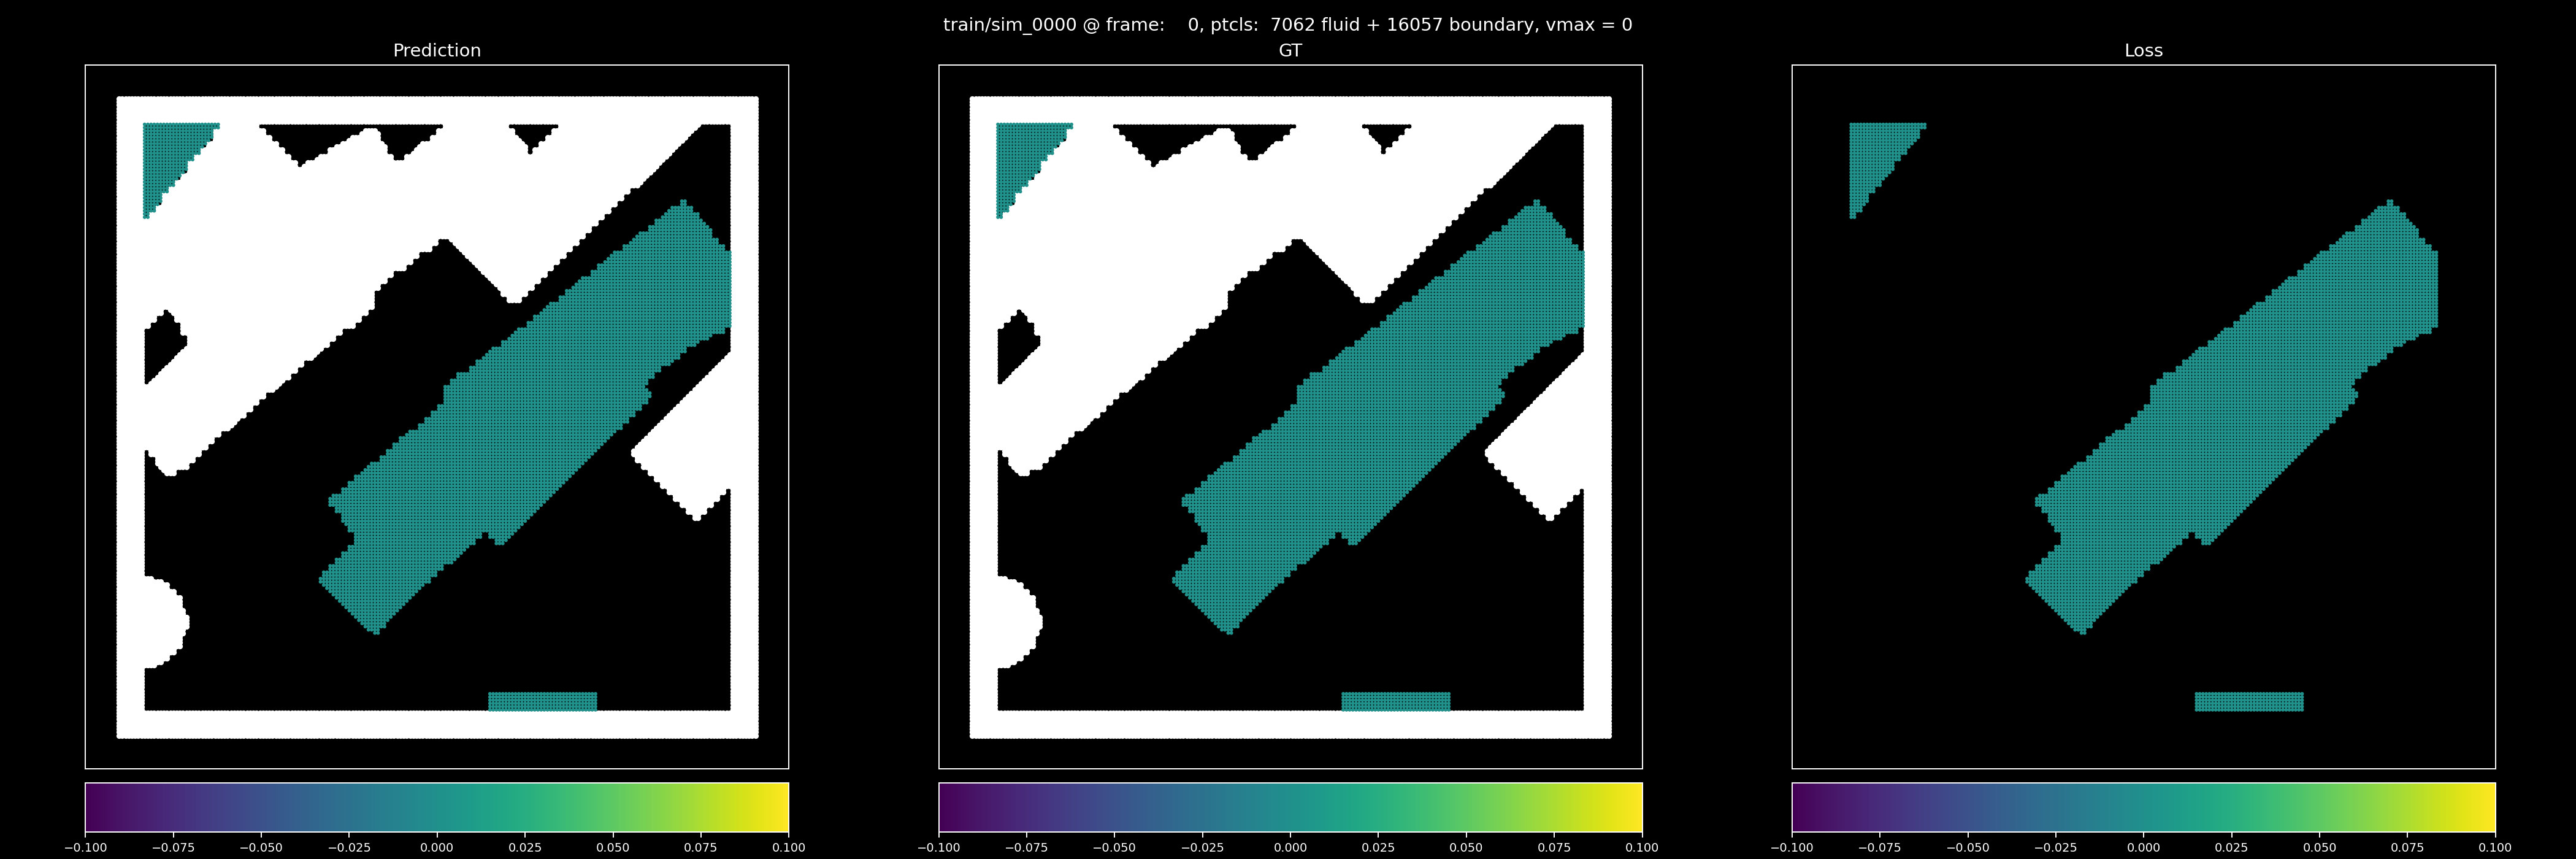

/home/winchenbach/anaconda3/envs/torch/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:11: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(Dropdown(description='fileName', options=('train/sim_0000.hdf5', 'train/sim_0002.hdf5', …

<function __main__.plotNetwork(fileName, frame)>

In [3]:
def plotNetwork(fileName, frame):
    global prevFile, prevFrame   
    
    file = basePath + '/' + fileName
    
    if file != prevFile:
        frameSlider.max = getFrameCount(file) - 1
        frameSlider.value = 0
        frame = 0        
    attributes, inputData, groundTruthData = loadFrame(file, frame, 1 + np.arange(0), 1)        
    if file != prevFile:
        bdyScatter0.set_offsets(inputData['boundaryPosition'][:,:2])
        bdyScatter1.set_offsets(inputData['boundaryPosition'][:,:2])
#         bdyScatter2.set_offsets(inputData['boundaryPosition'][:,:2])
        prevFile = file        
    if frame != prevFrame:
        prevFrame = frame
    data = torch.linalg.norm(inputData['fluidVelocity'],dim=1).detach().cpu().numpy()
    positions = inputData['fluidPosition'].detach().cpu().numpy()
    sc0.set_offsets(positions)
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    sc1.set_offsets(positions)
    sc1.set_array(data)
    cbar1.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    sc2.set_offsets(positions)
    sc2.set_array(data)
    cbar2.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))        
    
#     axis[0,0].set_title('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.suptitle('%s @ frame: %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g' % (fileName.split('.')[0], frame, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data)))
    fig.canvas.draw()
    fig.canvas.flush_events()
   

fig, axis = plt.subplots(1, 3, figsize=(24,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].axis('equal')
axis[0,0].set_xlim(-0.05,1.05)
axis[0,0].set_ylim(-0.05,1.05)
axis[0,1].axis('equal')
axis[0,1].set_xlim(-0.05,1.05)
axis[0,1].set_ylim(-0.05,1.05)
axis[0,2].axis('equal')
axis[0,2].set_xlim(-0.05,1.05)
axis[0,2].set_ylim(-0.05,1.05)

attributes, inputData, groundTruthData = loadFrame(simulationFiles[0], 0, 1 + np.arange(1), 1)
x = inputData['fluidPosition'][:,0].detach().cpu().numpy()
y = inputData['fluidPosition'][:,1].detach().cpu().numpy()
v = torch.linalg.norm(inputData['fluidVelocity'],dim=1)

bdyScatter0 = axis[0,0].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
bdyScatter1 = axis[0,1].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )
# bdyScatter2 = axis[0,2].scatter(inputData['boundaryPosition'][:,0], inputData['boundaryPosition'][:,1], c = 'white', s =8 )

sc0 = axis[0,0].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar0 = fig.colorbar(sc0, cax=cax1,orientation='horizontal')
cbar0.ax.tick_params(labelsize=8) 

sc1 = axis[0,1].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar1 = fig.colorbar(sc1, cax=cax1,orientation='horizontal')
cbar1.ax.tick_params(labelsize=8) 

sc2 = axis[0,2].scatter(x,y,c = v.detach().cpu().numpy(), s= 2)
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="7%", pad="2%")
cbar2 = fig.colorbar(sc2, cax=cax1,orientation='horizontal')
cbar2.ax.tick_params(labelsize=8) 

fig.suptitle('%s @ %2d' % (simulationFiles[0].split('/')[-1].split('.')[0], 0))
axis[0,0].set_title('Prediction')
axis[0,1].set_title('GT')
axis[0,2].set_title('Loss')
    
prevFile = None
prevFrame = None
        
axis[0,0].set_xticks([], [])
axis[0,0].set_yticks([], [])
axis[0,1].set_xticks([], [])
axis[0,1].set_yticks([], [])
axis[0,2].set_xticks([], [])
axis[0,2].set_yticks([], [])
    
frameSlider = widgets.IntSlider(value=0, min=0, max=getFrameCount(simulationFiles[0]) - 1, step=1)

fig.tight_layout()

interact(plotNetwork, fileName = simFiles, frame = frameSlider)

In [113]:
print(prevFile)
print(prevFrame)
fileName = prevFile
frameIndex = prevFrame
    
# params = getRbfNetworkParams(fileName, frameIndex)
attributes, inputData, groundTruthData = loadFrame(fileName, frameIndex, 0 + np.arange(1))
inputData['fluidGravity'] = inputData['fluidGravity'][:,:2]
fluidPositions, boundaryPositions, fluidFeatures, boundaryFeatures = constructFluidFeatures(attributes, inputData)
gt = getGroundTruth(fileName, 10)

predictedPositions = inputData['fluidPosition'].to(device)
predictedVelocities = inputData['fluidVelocity'].to(device)
dt = attributes['dt']

pr_pos = tf.convert_to_tensor(predictedPositions.detach().cpu().numpy())
pr_vel = tf.convert_to_tensor(predictedVelocities.detach().cpu().numpy())
acc = tf.convert_to_tensor(inputData['fluidGravity'].detach().cpu().numpy())

box = tf.convert_to_tensor(boundaryPositions.detach().cpu().numpy())
box_normals = tf.convert_to_tensor(boundaryFeatures.detach().cpu().numpy())

pr_pos = tf.concat ([pr_pos, tf.zeros((pr_pos.shape[0],1))], axis = 1)
pr_vel = tf.concat ([pr_vel, tf.zeros((pr_pos.shape[0],1))], axis = 1)
acc = tf.concat ([acc, tf.zeros((pr_pos.shape[0],1))], axis = 1)

box = tf.concat ([box, tf.zeros((box.shape[0],1))], axis = 1)
box_normals = tf.concat ([box_normals, tf.zeros((box_normals.shape[0],1))], axis = 1)


for i in range(1, 128):
    inputs = (pr_pos, pr_vel, acc, None, box, box_normals)
    pr_pos, pr_vel = pipeline.model(inputs, training=False)    
    
    gt = getGroundTruth(fileName, prevFrame + i)
#     predictedPositions, predictedVelocities, loss = runRbfNetwork(predictedPositions, predictedVelocities, attributes['dt'], 1, params, gt, True)
    
    data = np.linalg.norm(pr_vel.numpy(),axis=1)    
    sc0.set_offsets(pr_pos.numpy())
    sc0.set_array(data)
    cbar0.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))    
    
    gtdata = np.linalg.norm(gt[1].detach().cpu().numpy(), axis = 1)
    sc1.set_offsets(gt[0].detach().cpu().numpy())
    sc1.set_array(gtdata)
    sc2.set_offsets(gt[0].detach().cpu().numpy())
#     sc2.set_array(loss.detach().cpu().numpy())
    
    fig.suptitle('%s @ frame: %4d + %4d, ptcls: %5d fluid + %5d boundary, vmax = %.4g, mean loss = %.4g' % (prevFile.split('/')[-1].split('.')[0], prevFrame, i, inputData['fluidPosition'].shape[0], inputData['boundaryPosition'].shape[0], np.max(data), 0.))
    fig.canvas.draw()
    fig.canvas.flush_events()
    


/home/winchenbach/dev/datasets/WBCSPH2Dc/train/sim_0000.hdf5
1319


KeyboardInterrupt: 

In [36]:
print(tf.zeros((pr_pos.shape[0],1)).shape)
print(pr_pos.shape)

(7062, 1)
(7062, 2)


In [41]:
box_normals.shape

TensorShape([16057, 2])

In [46]:
pos.numpy()

array([[0.27092844, 0.29851145, 0.        ],
       [0.13834465, 0.04687183, 0.        ],
       [0.42875704, 0.0930602 , 0.        ],
       ...,
       [0.11584921, 0.93015003, 0.        ],
       [0.13045566, 0.954456  , 0.        ],
       [0.08369137, 0.9342278 , 0.        ]], dtype=float32)